In [42]:
from __future__ import division
import multiprocessing
import pandas as pd
import numpy as np
import psycopg2
import seattle_neighborhoods
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def database_connect(dbnm, username):
    '''
    INPUT: name of existing postgres database, username
    OUTPUT: database connection and cursor
    Take database name and username and establish conncetion to database
    '''
    conn = psycopg2.connect(dbname=dbnm, user=username, host='/tmp')
    c = conn.cursor()
    return conn, c

In [3]:
def remove_rows(df, colname, colval):
    '''
    INPUT: dataframe, column name, column value
    OUTPUT: dataframe
    take a dataframe and remove all rows in which the value for colname = colval
    '''
    return df[df[colname] != colval]

In [4]:
def remove_outliers(df, colname, iqr_mult):
    '''
    INPUT: dataframe, column name, multiplier for inter quartile range
    OUTPUT: dataframe
    take a dataframe and return a dataframe with outliers removed
    '''
    print colname
    q1 = df[colname].quantile(.25)
    q3 = df[colname].quantile(.75)
    iqr = df[colname].quantile(.75) - df[colname].quantile(.25)  # calculate interquartile range
    df = df[df[colname] >= q1 - iqr * iqr_mult]  # remove low outliers
    df = df[df[colname] <= q3 + iqr * iqr_mult]  # remove high outliers
    return df

In [5]:
def extract_from_database(dbname, user, table, cols):
    '''
    INPUT: database name, username, table name, columns to extract
    OUTPUT: dataframe
    take a postgres database, extract specified columns from it and return as a dataframe
    '''
    conn, c = database_connect('housingdata_clean', 'sydneydecoto')
    df = pd.DataFrame()
    for col in cols:
        c.execute('SELECT {} FROM {}'.format(col, table))
        df[col] = [val[0] for val in c.fetchall()]
    conn.commit()
    conn.close()
    return df

In [23]:
# get columns from database
params_list = ['v2014', 'v2015', 'v2016', 'hood', 'year', 'sq_ft', 'beds', 'baths', 'lot_size']
df = extract_from_database('housingdata_clean', 'sydneydecoto', 'housing_data', params_list)

# add columns for percent increase from 2014 to 2015 and percent increase from 2015 to 2016 (this will be y)
df['pct_inc15'] = (df['v2015'] - df['v2014']) / df['v2014']*100.
df['pct_inc16'] = (df['v2016'] - df['v2015']) / df['v2015']*100.

'''remove bad data (null values, zero home values)'''
df.dropna(axis=0, inplace=True)
df = remove_rows(df, 'v2014', 0)
df = remove_rows(df, 'v2015', 0)
df = remove_rows(df, 'v2016', 0)
df = remove_outliers(df, 'pct_inc16', 3)
df = remove_outliers(df, 'pct_inc15', 3)
df.info()

pct_inc16
pct_inc15
<class 'pandas.core.frame.DataFrame'>
Int64Index: 31683 entries, 0 to 36529
Data columns (total 11 columns):
v2014        31683 non-null int64
v2015        31683 non-null int64
v2016        31683 non-null int64
hood         31683 non-null object
year         31683 non-null int64
sq_ft        31683 non-null int64
beds         31683 non-null int64
baths        31683 non-null object
lot_size     31683 non-null int64
pct_inc15    31683 non-null float64
pct_inc16    31683 non-null float64
dtypes: float64(2), int64(7), object(2)
memory usage: 2.9+ MB


In [7]:
grouped = df.groupby(['hood']).mean()
hoods = np.array(grouped.index)
pctincs = np.array(grouped['pct_inc16'])

print '{} has maximum value increase of {}%'.format(hoods[pctincs == max(pctincs)][0], round(max(pctincs),1))
print '{} has minimum value increase of {}%'.format(hoods[pctincs == min(pctincs)][0], round(min(pctincs),1))

Sand Point has maximum value increase of 14.9%
Industrial District has minimum value increase of 3.3%


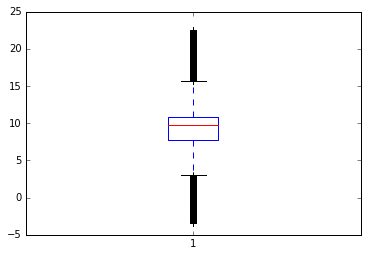

In [24]:
plt.boxplot(df['pct_inc16'])
plt.show()

In [25]:
q1 = df.pct_inc16.quantile(0.25)
q3 = df.pct_inc16.quantile(0.75)
iqr = q3 - q1

In [26]:
permits_2015 = pd.read_csv('data/permits_2015.csv')
permits_2015.columns

permits_2015['Value'] = permits_2015['Value'].replace('[$]', '', regex=True).astype(float)
permits_2015.head()

,Unnamed: 0,Application/Permit Number,Permit Type,Address,Description,Category,Action Type,Work Type,Value,Applicant Name,...,Final Date,Expiration Date,Status,Contractor,Permit and Complaint Status URL,Latitude,Longitude,Location,year,Neighborhood
0,7121,6504528,Construction,2700 4TH AVE S,Construct interior alterations to combine two ...,COMMERCIAL,ADD/ALT,Plan Review,20000.0,"BOZORTH, ROBERT",...,NaN,NaN,Reviews Completed,NaN,http://web6.seattle.gov/dpd/PermitStatus/Proje...,47.579402,-122.328491,"(47.57940232, -122.32849072)",2015.0,Industrial District
1,7122,6511706,Construction,9616 27TH AVE NW,"Alterations to single family residence, subjec...",SINGLE FAMILY / DUPLEX,ADD/ALT,No plan review,8000.0,"SIMONDS, DYLAN",...,NaN,06/30/2017,Permit Issued,NaN,http://web6.seattle.gov/dpd/PermitStatus/Proje...,47.699188,-122.392099,"(47.6991885, -122.39209858)",2015.0,North Beach/Blue Ridge
2,7123,6511726,Construction,5019 57TH AVE S,Interior remodel to existing single family res...,SINGLE FAMILY / DUPLEX,ADD/ALT,No plan review,151000.0,"SCOFIELD, ALEX",...,07/28/2016,06/30/2017,Permit Closed,NaN,http://web6.seattle.gov/dpd/PermitStatus/Proje...,47.556438,-122.264005,"(47.55643815, -122.26400533)",2015.0,Seward Park
3,7124,6511226,Construction,5520 17TH AVE NE,Construct alterations to basement of existing ...,SINGLE FAMILY / DUPLEX,ADD/ALT,No plan review,7000.0,"CHOW, LYDIA",...,07/26/2016,06/30/2017,Permit Closed,NaN,http://web6.seattle.gov/dpd/PermitStatus/Proje...,47.669221,-122.309135,"(47.66922134, -122.30913479)",2015.0,University District
4,7125,6511623,Construction,1413 E ALOHA ST,Construct repairs to a fire damaged single fam...,SINGLE FAMILY / DUPLEX,ADD/ALT,No plan review,100000.0,"CHINN, SHELLY",...,05/19/2016,06/30/2017,Permit Closed,NaN,http://web6.seattle.gov/dpd/PermitStatus/Proje...,47.626558,-122.313917,"(47.62655839, -122.31391727)",2015.0,Broadway


In [11]:
def get_permit_count(df, hood, category):
    return df.loc[(df['Neighborhood'] == hood) & (df['Category'] == category), 'Value'].count()

In [12]:
def get_permit_sum(df, hood, category):
    return df.loc[(df['Neighborhood'] == hood) & (df['Category'] == category), 'Value'].sum()

In [27]:
print df.head()

     v2014    v2015    v2016            hood  year  sq_ft  beds baths  \
0   243000   273000   294000        Atlantic  1921    610     1  1.00   
1  1065000  1318000  1443000     Portage Bay  1925   3970     4  3.00   
2   171000   198000   227000   Highland Park  1942    750     2  1.00   
3   301000   303000   337000      Holly Park  2005   1770     3  3.50   
4   384000   420000   449000  Matthews Beach  1955   1410     3  1.00   

   lot_size  pct_inc15  pct_inc16  
0      3360  12.345679   7.692308  
1      5500  23.755869   9.484067  
2      4876  15.789474  14.646465  
3      2253   0.664452  11.221122  
4      5355   9.375000   6.904762  


In [14]:
chk = permits_2015.loc[(permits_2015['Neighborhood'] == 'Industrial District') &  (permits_2015['Category'] == 'COMMERCIAL'),'Value']
chk = permits_2015.loc[(permits_2015['Neighborhood'] == 'Industrial District'),'Value']
# get total number of permits in that neighborhood
house_hoods = df['hood']
total_permit_count = []
total_permit_value = []
comm_ct = []
sf_ct = []
mf_ct = []
inst_ct = []
ind_ct = []

comm_sum = []
sf_sum = []
mf_sum = []
inst_sum = []
ind_sum = []
for hood in house_hoods:
    total_permit_count.append(permits_2015.loc[permits_2015['Neighborhood'] == hood, 'Value'].count())
    total_permit_value.append(permits_2015.loc[permits_2015['Neighborhood'] == hood, 'Value'].sum())
    
    comm_ct.append(get_permit_count(permits_2015, hood, 'COMMERCIAL'))
    sf_ct.append(get_permit_count(permits_2015, hood, 'SINGLE FAMILY / DUPLEX'))
    mf_ct.append(get_permit_count(permits_2015, hood, 'MULTIFAMILY'))
    inst_ct.append(get_permit_count(permits_2015, hood, 'INSTITUTIONAL'))
    ind_ct.append(get_permit_count(permits_2015, hood, 'INDUSTRIAL'))
    
    comm_sum.append(get_permit_sum(permits_2015, hood, 'COMMERCIAL'))
    sf_sum.append(get_permit_sum(permits_2015, hood, 'SINGLE FAMILY / DUPLEX'))
    mf_sum.append(get_permit_sum(permits_2015, hood, 'MULTIFAMILY'))
    inst_sum.append(get_permit_sum(permits_2015, hood, 'INSTITUTIONAL'))
    ind_sum.append(get_permit_sum(permits_2015, hood, 'INDUSTRIAL'))

df['total_permits'] = total_permit_count
df['total_permit_val'] = total_permit_value
df['comm_ct'] = comm_ct
df['sf_ct'] = sf_ct
df['mf_ct'] = mf_ct
df['inst_ct'] = inst_ct
df['ind_ct'] = ind_ct

df['comm_sum'] = comm_sum
df['sf_sum'] = sf_sum
df['mf_sum'] = mf_sum
df['inst_sum'] = inst_sum
df['ind_sum'] = ind_sum
df.head(2)

,v2014,v2015,v2016,hood,year,sq_ft,beds,baths,lot_size,pct_inc15,...,comm_ct,sf_ct,mf_ct,inst_ct,ind_ct,comm_sum,sf_sum,mf_sum,inst_sum,ind_sum
0,243000,273000,294000,Atlantic,1921,610,1,1.00,3360,12.345679,...,16,46,21,4,0,1655435.0,9356542.0,16484584.0,181000.0,0.0
1,1065000,1318000,1443000,Portage Bay,1925,3970,4,3.00,5500,23.755869,...,3,15,0,1,0,55000.0,2085082.0,0.0,2234000.0,0.0


In [28]:
df['total_permits'] = total_permit_count
df['total_permit_val'] = total_permit_value
df['comm_ct'] = comm_ct
df['sf_ct'] = sf_ct
df['mf_ct'] = mf_ct
df['inst_ct'] = inst_ct
df['ind_ct'] = ind_ct

df['comm_sum'] = comm_sum
df['sf_sum'] = sf_sum
df['mf_sum'] = mf_sum
df['inst_sum'] = inst_sum
df['ind_sum'] = ind_sum
df.head(2)

,v2014,v2015,v2016,hood,year,sq_ft,beds,baths,lot_size,pct_inc15,...,comm_ct,sf_ct,mf_ct,inst_ct,ind_ct,comm_sum,sf_sum,mf_sum,inst_sum,ind_sum
0,243000,273000,294000,Atlantic,1921,610,1,1.00,3360,12.345679,...,16,46,21,4,0,1655435.0,9356542.0,16484584.0,181000.0,0.0
1,1065000,1318000,1443000,Portage Bay,1925,3970,4,3.00,5500,23.755869,...,3,15,0,1,0,55000.0,2085082.0,0.0,2234000.0,0.0


In [35]:
df_hood = pd.get_dummies(df['hood'])
df_new = pd.concat([df, df_hood], axis=1)
df_new.drop('hood', axis=1, inplace=True)

In [36]:
y = df_new['pct_inc16']
X = df_new.drop(['v2016', 'pct_inc16'], axis=1)

In [37]:
# X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [39]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
print model.score(X_test, y_test)

0.406679631994


In [46]:
def grid_search(est, grid):
    grid_cv = GridSearchCV(est, grid, n_jobs=-1, verbose=False).fit(X_train, y_train)
    return grid_cv

In [ ]:
gd_grid = {'learning_rate': [.1, 0.06, 0.058, .056, .03],
           'max_depth': [5, 10, 20, 30, 40, 50],
           'min_samples_leaf': [1, 5, 10, 15, 20],
           'max_features': [.9, 0.6, 0.25, 0.23, .2, .1, .01],
           'n_estimators': [100],
           'random_state': [1]}


gd_grid_search = grid_search(GradientBoostingRegressor(), gd_grid)

In [ ]:
gd_best = gd_grid_search.best_estimator_
gd_grid_search.best_params_

In [61]:
model = GradientBoostingRegressor(learning_rate=0.058, max_depth=30, max_features=0.23, min_samples_leaf=10,
                                  n_estimators=100)
model.fit(X_train, y_train)
print model.score(X_test, y_test)

0.602755924268


### Load building permit data and clean dataframe

In [ ]:
# df_permits = pd.read_csv('data/permitting.csv')  # Load the data from csv
# dates = pd.to_datetime(df_permits['Application Date'])  # Convert Application Date column to datetime
# df_permits['year'] = [d.year for d in dates]   # Retrieve year from date and add year column to dataframe

In [ ]:
# df_permits = df_permits[df_permits.year == 2015]  # keep all 2015 data
# df_permits.dropna(axis=0, subset=['Latitude', 'Longitude'], inplace=True)  # drop rows with no latitude and longitude
# print df_permits.head()

In [ ]:
# lons = df_permits['Longitude']
# lats = df_permits['Latitude']

# print len(lons)
# print len(lats)

In [ ]:
from __future__ import division
import psycopg2
import pandas as pd
import numpy as np
from matplotlib.patches import Polygon
import matplotlib
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
import fiona
from descartes import PolygonPatch
import matplotlib.pyplot as plt
from collections import defaultdict
# from matplotlib.path.Path import contains_points


def parse_shapes(shapefilepath):
    '''Read in a shape file (.shp) and return coordinates and dataframe for plotting'''
    shp = fiona.open(shapefilepath+'.shp')
    coords = shp.bounds
    shp.close
    return coords


def plot_prepper(m, shapefilename, df_key):
    '''Generate dataframe for plotting'''
    _out = m.readshapefile(shapefilename, name='seattle', drawbounds=False, color='none', zorder=2)
    # set up a map dataframe for neighborhood outlines
    cent_lons = [float((Polygon(points).centroid.wkt).split()[1][1:]) for points in m.seattle]
    cent_lats = [float((Polygon(points).centroid.wkt).strip(')').split()[2]) for points in m.seattle]

    df = pd.DataFrame({
        'poly': [Polygon(points) for points in m.seattle],
        'name': [item[df_key] for item in m.seattle_info],
    })
    df['centroid_1'] = cent_lons
    df['centroid_2'] = cent_lats
    return _out, df

# Read in neighborhood shape file

hood_shapefilename = '/Users/sydneydecoto/Documents/PythonScripts/Neighborhoods/WGS84/Neighborhoods'
hood_coords = parse_shapes(hood_shapefilename)

w, h = hood_coords[2] - hood_coords[0], hood_coords[3] - hood_coords[1]
extra = 0.005

# Initialize the plot
figwidth = 8
fig = plt.figure(figsize=(figwidth, figwidth*h/w))
ax = fig.add_subplot(111, axisbg='w', frame_on=False)
m = Basemap(
    projection='tmerc', ellps='WGS84',
    lon_0=np.mean([hood_coords[0], hood_coords[2]]),
    lat_0=np.mean([hood_coords[1], hood_coords[3]]),
    llcrnrlon=hood_coords[0] - extra * w,
    llcrnrlat=hood_coords[1] - (extra * h),
    urcrnrlon=hood_coords[2] + extra * w,
    urcrnrlat=hood_coords[3] + (extra * h),
    resolution='i',  suppress_ticks=True)

# get dataframe for plotting
_out, df_map = plot_prepper(m, hood_shapefilename, 'S_HOOD')
nbr_names = df_map['name'].unique()

pt = []
labels = []
count = 0

pt = [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(lons, lats)]

# for mapped_x, mapped_y in zip(lons, lats):
#     count = count + 1
#     xpt, ypt = m(mapped_x, mapped_y)
#     pt.append(Point(xpt, ypt))
#     for polygon in df_map['poly']:
#         nm = df_map.loc[df_map['poly'] == polygon, 'name'].iloc[0]
#         if polygon.contains(Point(xpt, ypt)) and len(nm.strip()) >= 4:
#             print count
#             labels.append(nm)
#             continue




In [ ]:
# def get_neighborhood(p):
#     label = 'no neighborhood'
#     for polygon in df_map['poly']:
#         nm = df_map.loc[df_map['poly'] == polygon, 'name'].iloc[0]
#         if polygon.contains(p) and len(nm.strip()) >= 4:
#             print nm
#             return nm
#     return label

In [ ]:
# pool = multiprocessing.Pool(4)
# output = pool.map(get_neighborhood, pt)

In [ ]:
# l = get_neighborhood(pt[0])

In [ ]:
# print l

In [ ]:
# df_permits['Neighborhood'] = output

In [ ]:
# df_permits.to_csv('data/permits_2015.csv')